<a href="https://colab.research.google.com/github/Praveengovianalytics/50DaysofRecomSystem/blob/main/Day5_Content_based_filtering_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                             #50DaysofRecommendationSystems




<a id='CBRS'></a>
# Collabrative filtering Recommender System


Let us understand this with an example. If person A likes 3 movies, say Interstellar, Inception and Predestination, and person B likes Inception, Predestination and The Prestige, then they have almost similar interests. We can say with some certainty that A should like The Prestige and B should like Interstellar. The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. There are different types of collaborating filtering techniques and we shall look at them in detail below. 


### User-User collaborative filtering

This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.


In terms of our movies example from earlier, this algorithm finds the similarity between each user based on the ratings they have previously given to different movies. The prediction of an item for a user u is calculated by computing the weighted sum of the user ratings given by other users to an item i.


### Item-Item collaborative filtering

In this algorithm, we compute the similarity between each pair of items.

So in our case we will find the similarity between each movie pair and based on that, we will recommend similar movies which are liked by the users in the past. This algorithm works similar to user-user collaborative filtering with just a little change – instead of taking the weighted sum of ratings of “user-neighbors”, we take the weighted sum of ratings of “item-neighbors”. 



# Day 5 - Item based collabrative filtering - KNN 

[To read more about the dataset used below](http://files.grouplens.org/datasets/movielens/ml-25m-README.html)

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip


--2020-11-13 15:50:18--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2020-11-13 15:50:19 (7.67 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [5]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [24]:
!pip install fuzzywuzzy


#Importing the required libraries

In [25]:
import pandas as pd 
import numpy as np
import random
import re 
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import gc

# data science imports
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')



# Importing the dataset

In [8]:
movies_dataset=pd.read_csv('ml-latest-small/movies.csv')
ratings_dataset=pd.read_csv('ml-latest-small/ratings.csv')

In [9]:
movies_dataset.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
ratings_dataset.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
movies_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [12]:
ratings_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Five point Statistical Summary

In [13]:
ratings_dataset.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


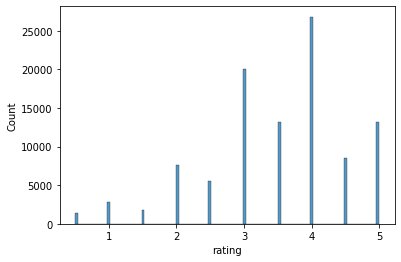

In [14]:
sns.histplot(ratings_dataset['rating'])

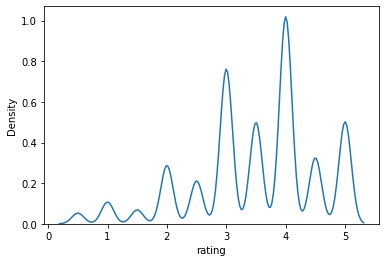

In [15]:
sns.kdeplot(ratings_dataset['rating'])

# Observation :- 

Good to see average movie rating is 3.5 

# Design Collaborative Filtering Item based recommender

In [16]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = ratings_dataset.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [19]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# convert dataframe of movie features to scipy sparse matrix

In [20]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [21]:
mat_movie_features

<9724x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [27]:
hashmap = { movie: i for i, movie in enumerate(list(movies_dataset.set_index('movieId').loc[df_movie_features.index].title)) }

Now our training data has a very high dimensionality. KNN’s performance will suffer from curse of dimensionality if it uses “euclidean distance” in its objective function. Euclidean distance is unhelpful in high dimensions because all vectors are almost equidistant to the search query vector (target movie’s features). Instead, we will use cosine similarity for nearest neighbor search. There is also another popular approach to handle nearest neighbor search in high dimensional data, [locality sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), which we won’t cover in this post.

# Configuring KNN model with Hyperparameters 

In [34]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1) # n=-1 means model uses all your CPU processor code for training

# Training model

In [36]:

model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

# Inference

In [43]:
MOVIE_NAME='Jumanji (1995)'
n_recommendations=10

In [44]:
distances, indices = model_knn.kneighbors(mat_movie_features[hashmap[MOVIE_NAME]],n_neighbors=n_recommendations+1)

# Lets compile the recommendation from the model

In [47]:
raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )[:0:-1]

In [48]:
raw_recommends

[(276, 0.5026324920929268),
 (18, 0.5024397358631021),
 (512, 0.492542010867402),
 (506, 0.484380023149225),
 (483, 0.48183868044092715),
 (504, 0.475123579391069),
 (418, 0.46195443302270334),
 (325, 0.45501892320213067),
 (436, 0.4501818938444998),
 (322, 0.4115622741415874)]

In [51]:
reverse_hashmap = {v: k for k, v in hashmap.items()}

print('Recommendations for {}:'.format(MOVIE_NAME))

for i, (idx, dist) in enumerate(raw_recommends):
  print('{0}: {1}, with distance of {2}'.format(i+1, reverse_hashmap[idx], dist))

Recommendations for Jumanji (1995):
1: Santa Clause, The (1994), with distance of 0.5026324920929268
2: Ace Ventura: When Nature Calls (1995), with distance of 0.5024397358631021
3: Beauty and the Beast (1991), with distance of 0.492542010867402
4: Aladdin (1992), with distance of 0.484380023149225
5: Nightmare Before Christmas, The (1993), with distance of 0.48183868044092715
6: Home Alone (1990), with distance of 0.475123579391069
7: Jurassic Park (1993), with distance of 0.46195443302270334
8: Mask, The (1994), with distance of 0.45501892320213067
9: Mrs. Doubtfire (1993), with distance of 0.4501818938444998
10: Lion King, The (1994), with distance of 0.4115622741415874


#...... To be continued ; See you 👍😊✌🏽on Day 6 